In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf

In [57]:
tickers = ['JPM', 'GS', 'AAPL', 'NFLX']
end = datetime.now()
start = end - timedelta(days=3650)
interval = '1d'
end = end.strftime('%Y-%m-%d')
start = start.strftime('%Y-%m-%d')

In [58]:
# https://github.com/ranaroussi/yfinance/issues/2422
# fixes yfinance rate limits by adding headers
from curl_cffi import requests
session = requests.Session(impersonate="chrome")
ticker = yf.Ticker('...', session=session)

# adjust for dividends
download = yf.download(tickers=tickers, start=start, end=end, interval=interval, group_by='ticker' , auto_adjust=True)

adjusted_close = download.xs('Close', axis=1, level=1).copy()

adjusted_close

[*********************100%***********************]  4 of 4 completed


Ticker,NFLX,AAPL,GS,JPM
Date,,,,
2015-06-24,96.944283,28.692390,175.352097,52.450138
2015-06-25,94.891426,28.555771,174.035522,52.168953
2015-06-26,93.088570,28.387796,174.321808,52.396923
2015-06-29,92.231430,27.890589,169.807724,51.067070
2015-06-30,93.848572,28.092159,170.739944,51.492630
...,...,...,...,...
2025-06-13,1212.150024,196.449997,613.539978,264.950012
2025-06-16,1225.349976,198.419998,627.849976,270.359985
2025-06-17,1220.670044,195.639999,624.640015,269.519989


In [59]:
# cleaning

# dont do ffill - messes up returns calculation later
# adjusted_close = adjusted_close.asfreq('B').ffill() # adds in missing business days (forward filling)

# simple daily returns - used log returns later for sharpe ratio
daily_returns = adjusted_close.pct_change().dropna()
daily_returns

Ticker,NFLX,AAPL,GS,JPM
Date,,,,
2015-06-25,-0.021176,-0.004762,-0.007508,-0.005361
2015-06-26,-0.018999,-0.005882,0.001645,0.004370
2015-06-29,-0.009208,-0.017515,-0.025895,-0.025380
2015-06-30,0.017534,0.007227,0.005490,0.008333
2015-07-01,-0.002268,0.009328,0.005508,0.011141
...,...,...,...,...
2025-06-13,-0.002370,-0.013805,-0.018509,-0.012265
2025-06-16,0.010890,0.010028,0.023324,0.020419
2025-06-17,-0.003819,-0.014011,-0.005113,-0.003107


In [60]:
# Save to CSV
adjusted_close.to_csv('data/adj_close.csv')
daily_returns.to_csv('data/returns.csv')

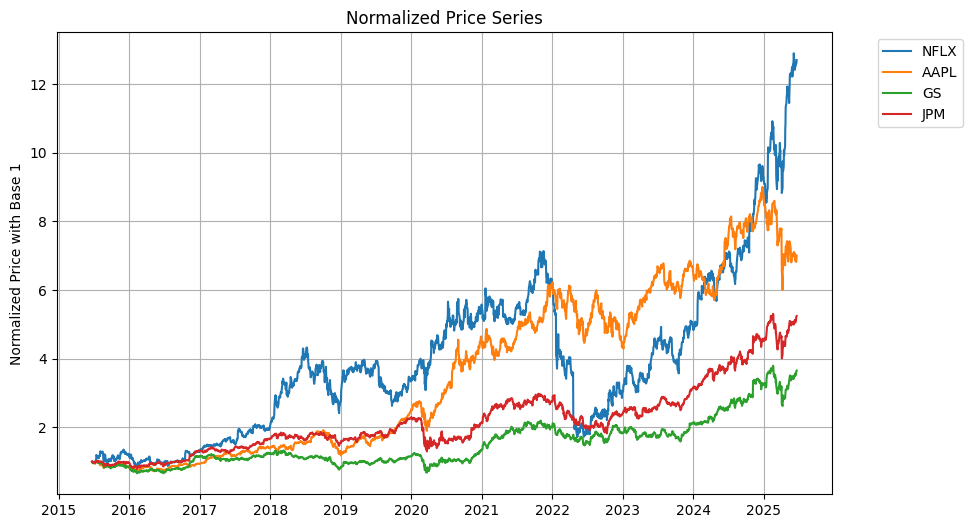

In [61]:
# Normalized Price Comparison

plt.figure(figsize=(10, 6))
for ticker in adjusted_close.columns:
    # divide price for each ticker by first value to normalize
    plt.plot(adjusted_close.index, adjusted_close[ticker]/adjusted_close[ticker].iloc[0], label=ticker)
plt.title("Normalized Price Series")
plt.ylabel('Normalized Price with Base 1')
# separates legend out incase of early highs
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

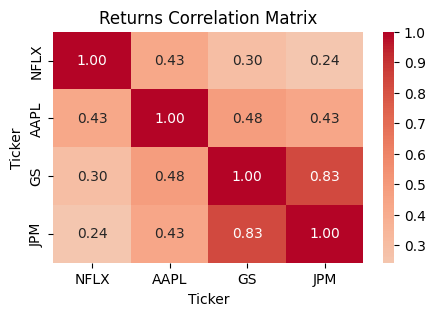

In [62]:
# Correlations

correlation_matrix = daily_returns.corr()

plt.figure(figsize=(5,3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title("Returns Correlation Matrix")
plt.show()

In [96]:
import pandas_datareader as pdr

# risk free rate 
# https://fred.stlouisfed.org/series/DGS3MO - 3-Month Treasury Bill Yield

# latest 3-month T-Bill yield (annualized)
rf_3mo = pdr.get_data_fred('DGS3MO').iloc[-1,0] / 100

# latest 10-year T-Bill yield (annualized)
rf_10y = pdr.data.DataReader('DGS10', 'fred').iloc[-1,0] / 100

# EAR formula to adjust for 252 day year
rf_10y_daily = (1 + rf_10y) ** (1/252) - 1

# Continuous-compounded (log) daily rate from annualized yield
rf_10y_daily_log = np.log(1 + rf_10y) / 252

print(rf_10y, rf_10y_daily, rf_10y_daily_log) 

0.0438 0.00017012518483539019 0.00017011071518720583


In [98]:
# Stats

# log returns
log_returns = np.log(adjusted_close / adjusted_close.shift(1)).dropna()

# Geometric means (or EAR formula) over simple returns
geometric_mean_s = (1 + daily_returns).prod() ** (252 / len(daily_returns)) - 1

# geometric return of log returns
geometric_mean_l = np.exp(log_returns.mean() * 252) - 1

# !! numpy default degrees of freedom is zero

annualized_volatility_s = daily_returns.std(ddof=1) * np.sqrt(252)
annualized_volatility_l = log_returns.std(ddof=1) * np.sqrt(252)

print(annualized_volatility_s, annualized_volatility_l) # basically the same
print("===========")
print(geometric_mean_s, geometric_mean_l) # basically the same

Ticker
NFLX    0.432442
AAPL    0.294316
GS      0.297305
JPM     0.277938
dtype: float64 Ticker
NFLX    0.438686
AAPL    0.294114
GS      0.297082
JPM     0.277502
dtype: float64
Ticker
NFLX    0.290445
AAPL    0.215660
GS      0.138834
JPM     0.180831
dtype: float64 Ticker
NFLX    0.290445
AAPL    0.215660
GS      0.138834
JPM     0.180831
dtype: float64


In [99]:
df = pd.DataFrame({
    "Annualized Returns": geometric_mean_l,
    # Potentially fix to use Newey-West adjusted standard deviation
    # "Annualized Volatility": daily_returns.std() * np.sqrt(252),
    "Annualized Volatility": annualized_volatility_l,
    "Sharpe Ratio": ((log_returns.mean() - rf_10y_daily_log) / log_returns.std(ddof=1)) * np.sqrt(252),
    # mauybe use rolling drawdown as time series
    "Max Drawdown": (adjusted_close / adjusted_close.cummax() - 1).min(),
    # if negatively skewed, there are rare but severe losses.
    "Skewness": log_returns.skew(),
    # how likely extreme events can happen - outlier likeliness
    "Kurtosis": log_returns.kurtosis()
    # avoid negative skew + high kurtosis
})

display(df.style.background_gradient(cmap='YlGnBu')) # colormaps for visibility - https://r02b.github.io/seaborn_palettes/

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,Skewness,Kurtosis
Ticker,,,,,,
NFLX,0.290445,0.438686,0.483534,-0.759473,-1.551420,29.817699
AAPL,0.215660,0.294114,0.518233,-0.385159,-0.105840,6.352461
GS,0.138834,0.297082,0.293310,-0.487488,-0.103576,9.190636
JPM,0.180831,0.277502,0.444504,-0.436265,-0.054287,13.008623
